In [1]:
import pandas as pd
import geopandas as gpd
import os
from matplotlib import pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
plt.rcParams.update({'font.size': 22})

path = os.getcwd()+"/safeguardedreleaseptaitorres202128062022/"

## UDBC data, lookup and shapefile

In [3]:
# http://ubdc.gla.ac.uk/dataset/public-transport-accessibility-indicators-2022
hospitals = pd.read_csv(path+"pt_accessibility_gb/output/accessibility/hospitals/access_hospital_pt.csv", low_memory=False)
gps = pd.read_csv(path+"pt_accessibility_gb/output/accessibility/gp/access_gp_pt.csv", low_memory=False)
local_codes = hospitals['geo_code']

In [4]:
#https://statistics.ukdataservice.ac.uk/dataset/2011-census-geography-boundaries-lower-layer-super-output-areas-and-data-zones
boundaries = gpd.read_file(path+"infuse_lsoa_lyr_2011/infuse_lsoa_lyr_2011.shp", low_memory=False)
boundaries = boundaries.loc[boundaries['geo_code'].isin(local_codes)]
boundaries = boundaries.merge(hospitals, on="geo_code")
boundaries = boundaries.merge(gps, on="geo_code")

In [5]:
boundaries['healthcare_30'] = boundaries['hospitals_30'] + boundaries['gp_number_30']
boundaries['healthcare_45'] = boundaries['hospitals_45'] + boundaries['gp_number_45']
boundaries['healthcare_60'] = boundaries['hospitals_60'] + boundaries['gp_number_60']
boundaries['healthcare_120'] = boundaries['hospitals_120'] + boundaries['gp_number_120']

Text(865010, 1271049, '+')

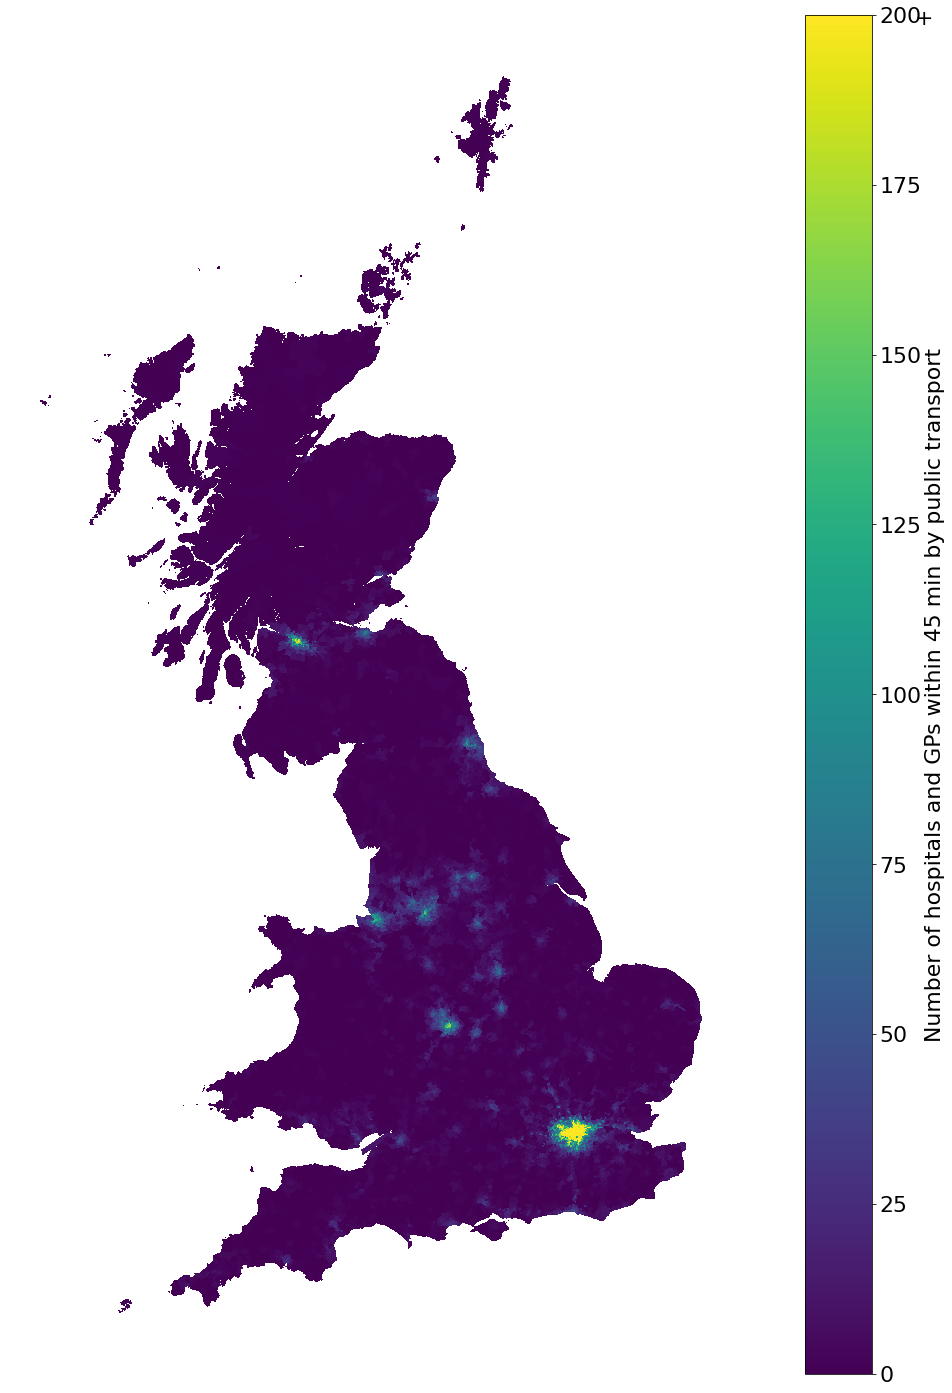

In [6]:
boundaries.plot(figsize=(25, 25),column='healthcare_45', legend=True,
          legend_kwds={'label': "Number of hospitals and GPs within 45 min by public transport"}, edgecolor="face", antialiased=False, vmax=200, linewidth=0.01)
plt.axis('off')
plt.text(865010, 1271049, '+')

76.79551391118886 %


/home/geompr/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-27010.800000000003, 688512.8, -55414.79290000001, 1281049.8949)

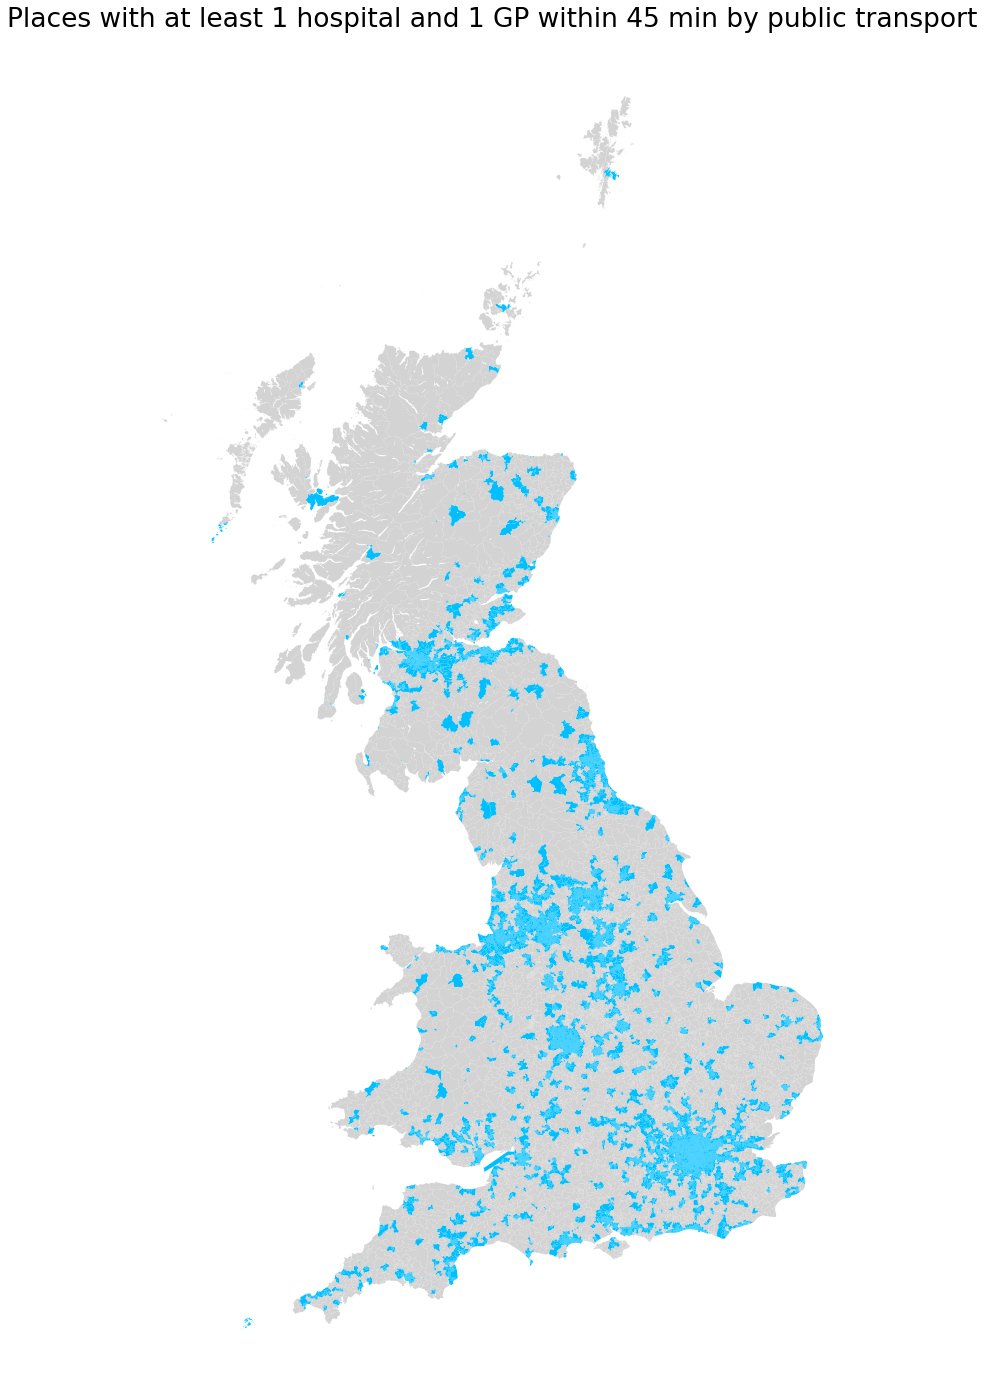

In [7]:
boundaries['one_hosp_one_gp'] = (boundaries['hospitals_45']>0)&(boundaries['gp_number_45']>0)
print(len(boundaries.loc[boundaries['one_hosp_one_gp']==True])/len(boundaries['one_hosp_one_gp'])*100.0,"%")
color = boundaries['one_hosp_one_gp'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries.plot(figsize=(25, 25),column ='one_hosp_one_gp',categorical=True, legend=True, color=color, edgecolor="face", linewidth=0.01)
plt.title("Places with at least 1 hospital and 1 GP within 45 min by public transport")
plt.axis('off')

In [8]:
# https://github.com/mysociety/uk_ruc
ruc = pd.read_csv(path+"RUC_unified.csv", low_memory=False)
ruc = ruc.rename(columns={"lsoa":'geo_code'})
boundaries = boundaries.merge(ruc, on ='geo_code')

<AxesSubplot:>

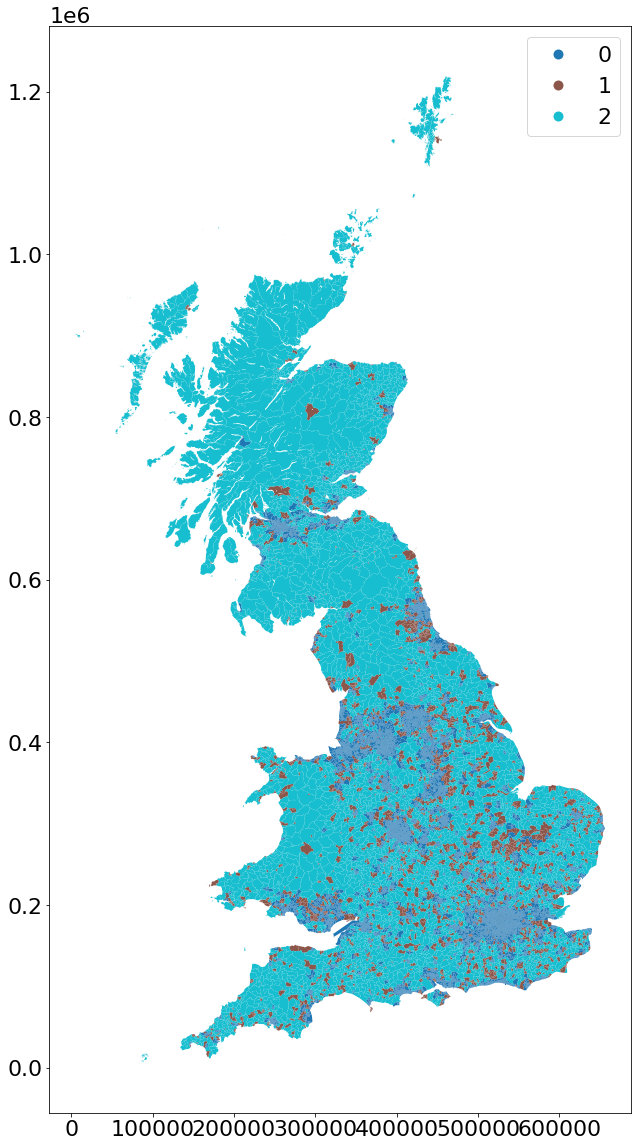

In [9]:
boundaries.plot(figsize=(25, 20),column ='ukruc-3', categorical=True, legend=True)

4.176951280883798 %


/home/geompr/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-27010.800000000003, 688512.8, -55414.79290000001, 1281049.8949)

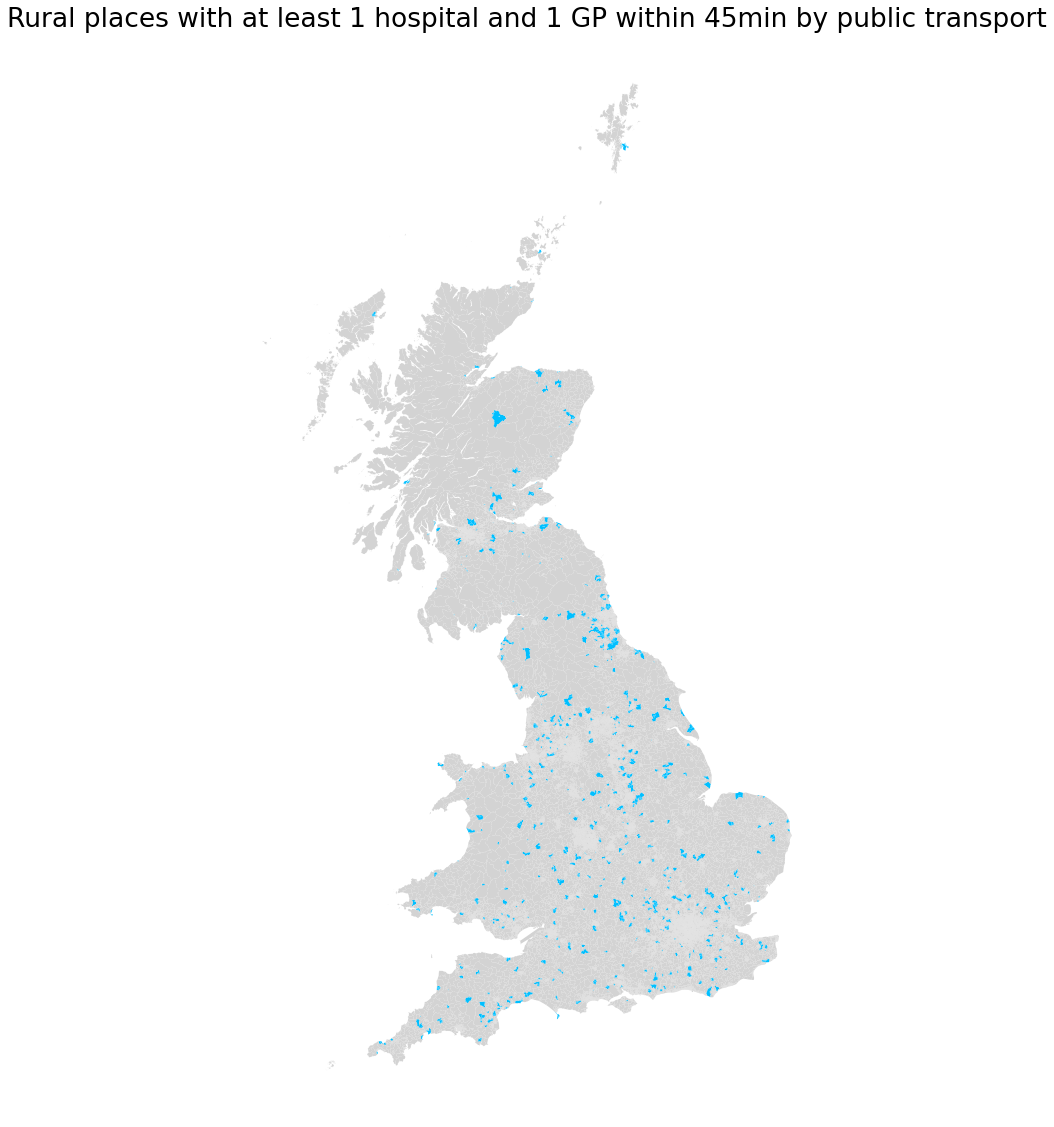

In [10]:
boundaries['one_hosp_one_gp_rural'] = (boundaries['one_hosp_one_gp'] == True) & (boundaries['ukruc-3'] == 1)
print(len(boundaries.loc[boundaries['one_hosp_one_gp_rural']==True])/len(boundaries['one_hosp_one_gp_rural'])*100.0,"%")
color_rural = boundaries['one_hosp_one_gp_rural'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries.plot(figsize=(25, 20),column ='one_hosp_one_gp_rural', categorical=True, legend=True, color=color_rural)
plt.title("Rural places with at least 1 hospital and 1 GP within 45min by public transport")
plt.axis('off')

## Population data

In [11]:
# https://statistics.gov.scot/resource?uri=http%3A%2F%2Fstatistics.gov.scot%2Fdata%2Fpopulation-estimates-detailed-current-geographic-boundaries
pop_scotland = pd.read_csv(path+"Population Estimates Detailed/SAPE_SYOA_All_2021.csv", low_memory=False)
pop_scotland = pop_scotland.rename(columns={"FeatureCode": "geo_code", "Value": 'pop'})

pop_scotland['Age'] = pop_scotland['Age'].apply(lambda age: age.split('years')[0])
pop_scotland['age'] = pop_scotland['Age'].astype(int)

pop_sc = pop_scotland.groupby('geo_code', as_index=False).sum('pop')[['geo_code', 'pop']]
seniors_sc = pop_scotland.loc[pop_scotland['age']>=80].groupby('geo_code', as_index=False).sum('pop')[['geo_code', 'pop']]
seniors_sc = seniors_sc.rename(columns={"pop": "seniors"})
pop_scotland = pop_sc.merge(seniors_sc, on="geo_code") 

# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates
xls = pd.ExcelFile(path+'sape23dt2mid2020lsoasyoaestimatesunformatted.xlsx')
pop_eng_wales = pd.read_excel(xls, 'Mid-2020 Persons', skiprows=4)
pop_eng_wales = pop_eng_wales.rename(columns={"LSOA Code": "geo_code", "All Ages": 'pop'})

pop_eng_wales['seniors'] = pop_eng_wales[[80,81,82,83,84,85,86,87,88,89,'90+']].sum(axis=1)

/home/geompr/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [12]:
pop_gb = pd.concat([pop_scotland[['geo_code', 'pop', 'seniors']],pop_eng_wales[['geo_code', 'pop', 'seniors']]])

In [13]:
geo_codes_deprived_45 = boundaries.loc[(boundaries['one_hosp_one_gp']== False), 'geo_code']

In [14]:
print(pop_gb['pop'].sum(), "people in GB")
print(pop_gb.loc[pop_gb['geo_code'].isin(geo_codes_deprived_45), "pop"].sum(), "people can't reach an hospital or a GP in 45 min by pt")
print(round(pop_gb.loc[pop_gb['geo_code'].isin(geo_codes_deprived_45), "pop"].sum()/pop_gb['pop'].sum()*100,2), "% people can't reach an hospital or a GP in 45 min by pt")

65199624 people in GB
14920613 people can't reach an hospital or a GP in 45 min by pt
22.88 % people can't reach an hospital or a GP in 45 min by pt


In [15]:
print(pop_gb["seniors"].sum(), "seniors 80+ in GB")
print(pop_gb.loc[(pop_gb['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum(), "seniors in GB can't reach an hospital or a GP in 45 min by pt")
print(round(pop_gb.loc[(pop_gb['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum()/pop_gb["seniors"].sum()*100,2), "% seniors in GB can't reach an hospital or a GP in 45 min by pt")

3305309 seniors 80+ in GB
902300 seniors in GB can't reach an hospital or a GP in 45 min by pt
27.3 % seniors in GB can't reach an hospital or a GP in 45 min by pt


## All Scotland

In [16]:
boundaries_scotland = boundaries.loc[boundaries['geo_code'].str.startswith('S01')]

(-17727.5, 493563.5, 495750.3650000008, 1254803.935)

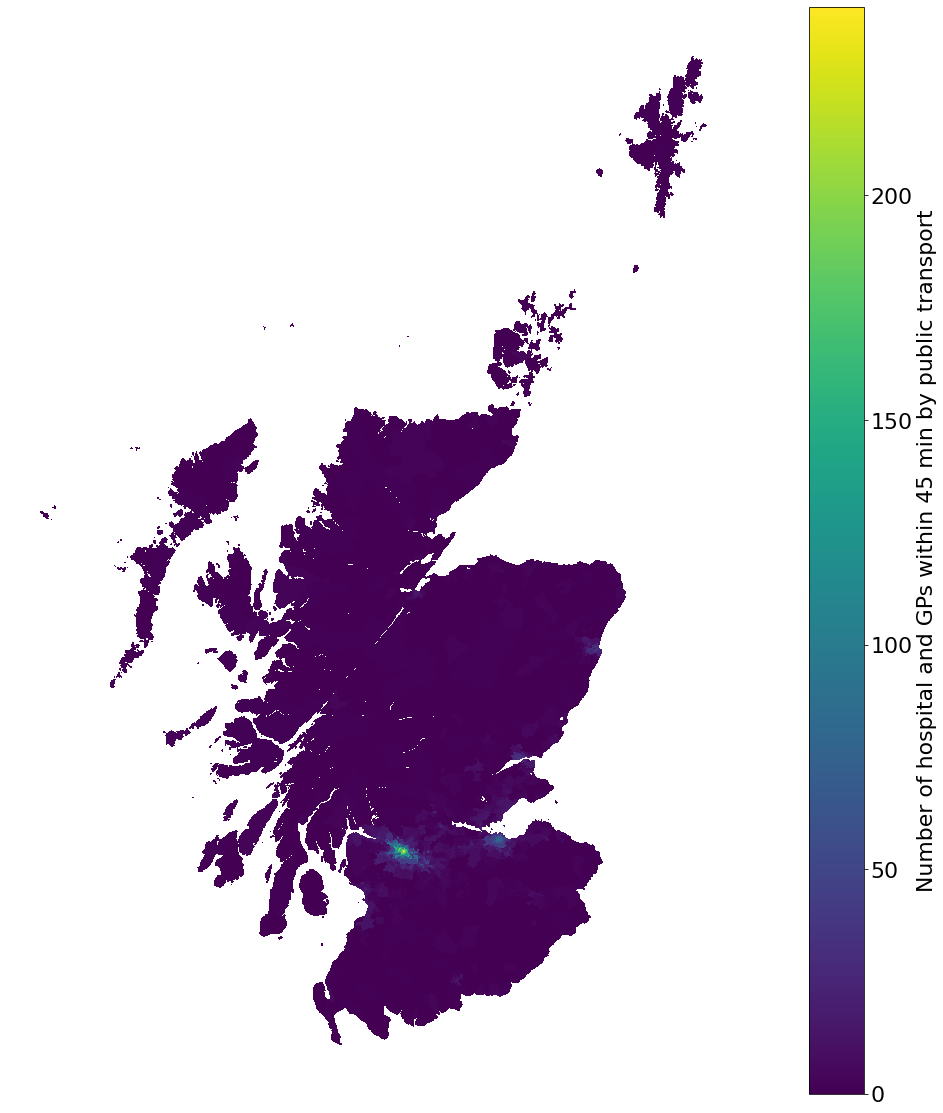

In [17]:
boundaries_scotland.plot(figsize=(25, 20),column='healthcare_45', legend=True,
          legend_kwds={'label': "Number of hospital and GPs within 45 min by public transport"},edgecolor="face", antialiased=False, linewidth=0.01)
plt.axis('off')


/home/geompr/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-17727.5, 493563.5, 495750.3650000008, 1254803.935)

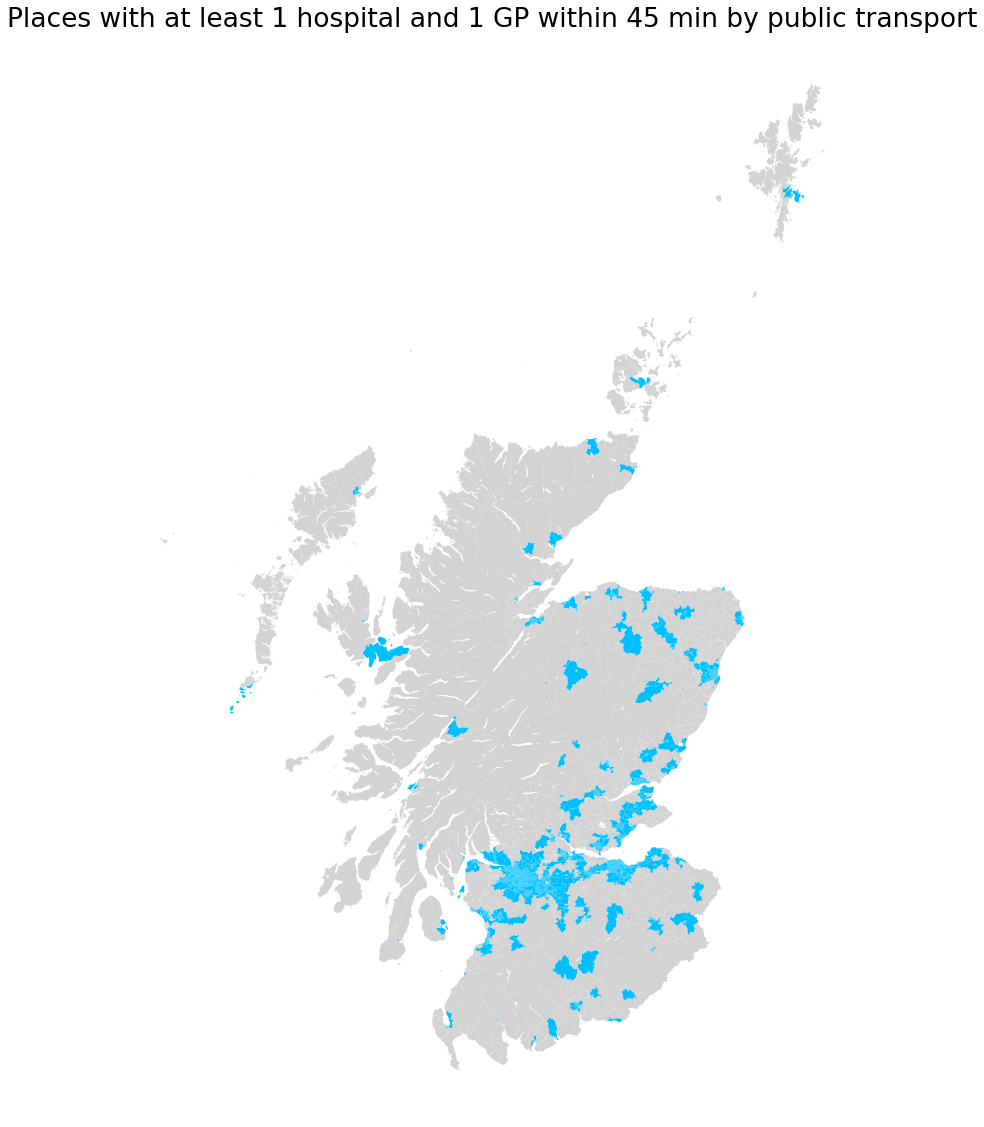

In [18]:
color = boundaries_scotland['one_hosp_one_gp'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries_scotland.plot(figsize=(25, 20),column ='one_hosp_one_gp',categorical=True, legend=True, color=color, edgecolor="face", linewidth=0.01)
plt.title("Places with at least 1 hospital and 1 GP within 45 min by public transport")
plt.axis('off')

(-17727.5, 493563.5, 495750.3650000008, 1254803.935)

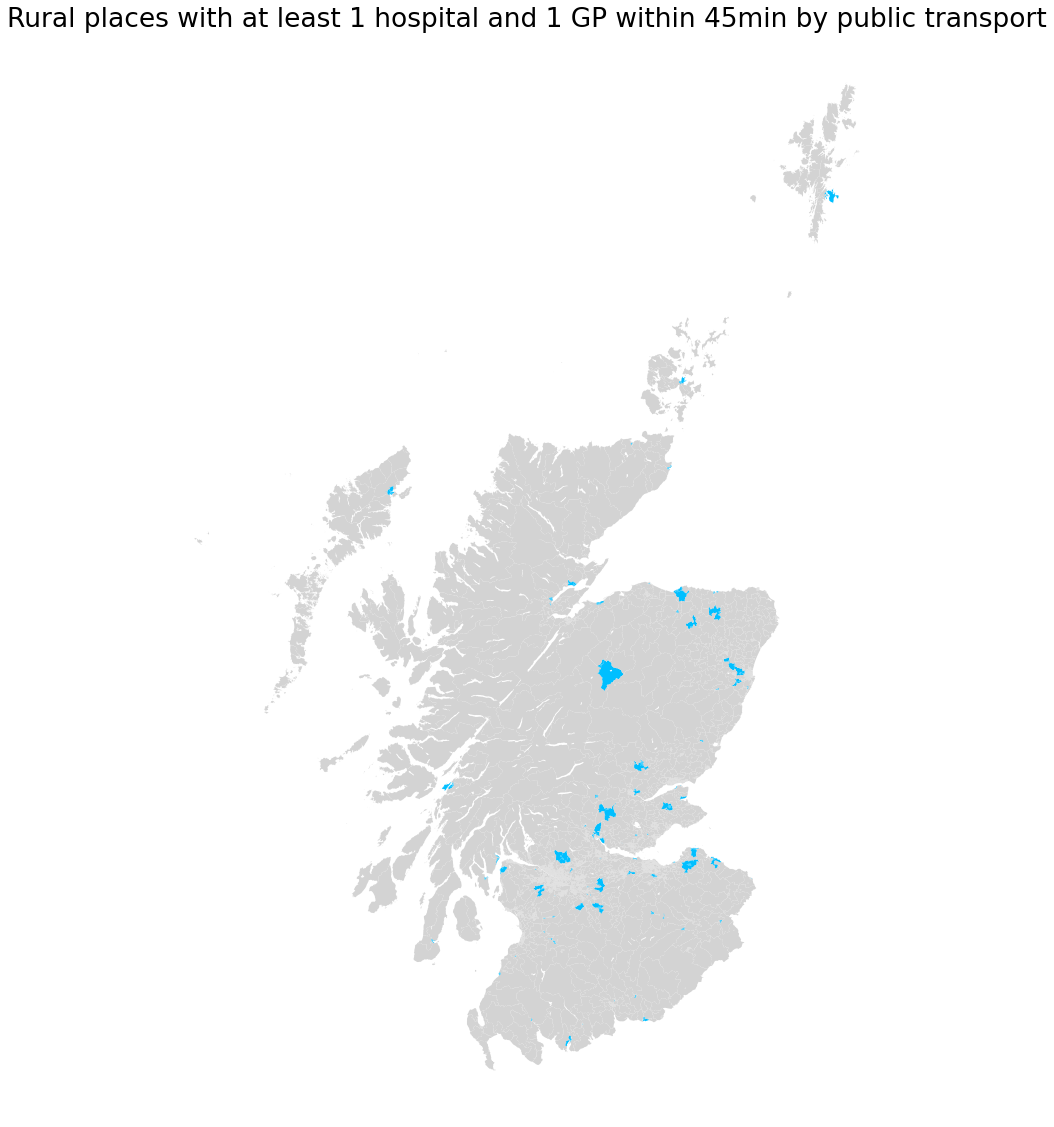

In [19]:
color_rural = boundaries_scotland['one_hosp_one_gp_rural'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries_scotland.plot(figsize=(25, 20),column ='one_hosp_one_gp_rural', categorical=True, legend=True, color=color_rural)
plt.title("Rural places with at least 1 hospital and 1 GP within 45min by public transport")
plt.axis('off')

In [20]:
pop_scotland = pop_gb.loc[pop_gb['geo_code'].str.startswith('S01')]
print(pop_scotland['pop'].sum(), "people in Scotland")
print(pop_scotland.loc[pop_scotland['geo_code'].isin(geo_codes_deprived_45), "pop"].sum(), "people can't reach an hospital and a GP in 45 min by pt")
print(round(pop_scotland.loc[pop_scotland['geo_code'].isin(geo_codes_deprived_45), "pop"].sum()/pop_scotland['pop'].sum()*100,2), "% people can't reach an hospital and a GP in 45 min by pt")

5479900 people in Scotland
1227129 people can't reach an hospital and a GP in 45 min by pt
22.39 % people can't reach an hospital and a GP in 45 min by pt


In [21]:
print(pop_scotland["seniors"].sum(), "seniors 80+ in Scotland")

print(pop_scotland.loc[(pop_scotland['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum(), "seniors in can't reach an hospital and a GP in 45 min by pt")
print(round(pop_scotland.loc[(pop_scotland['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum()/pop_scotland["seniors"].sum()*100,2), "% seniors in Scotland can't reach an hospital and a GP in 45 min by pt")


273984 seniors 80+ in Scotland
65162 seniors in can't reach an hospital and a GP in 45 min by pt
23.78 % seniors in Scotland can't reach an hospital and a GP in 45 min by pt


## Wales

In [22]:
boundaries_wales = boundaries.loc[boundaries['geo_code'].str.startswith('W01')]

(136161.30810000002, 365748.5979, 152965.62265, 407566.87834999996)

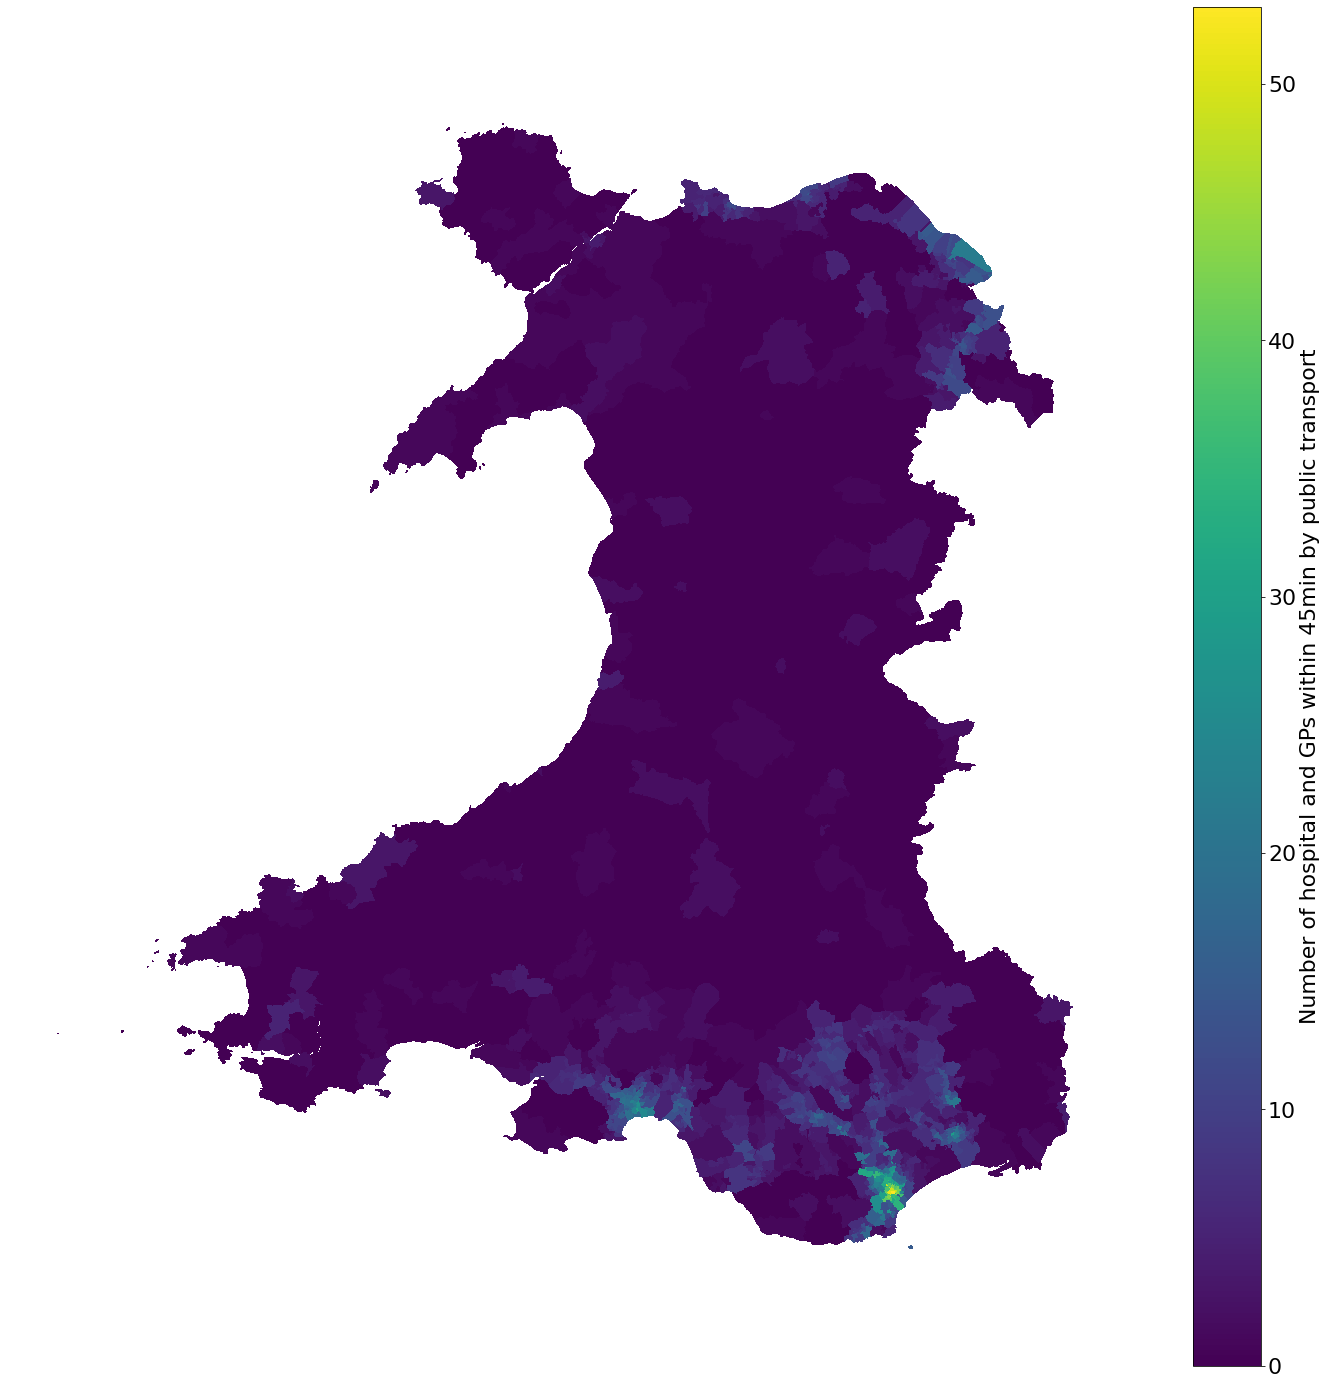

In [23]:
boundaries_wales.plot(figsize=(25, 25),column='healthcare_45', legend=True,
          legend_kwds={'label': "Number of hospital and GPs within 45min by public transport"},edgecolor="face", antialiased=False, linewidth=0.01)
plt.axis('off')

In [24]:
pop_wales = pop_gb.loc[pop_gb['geo_code'].str.startswith('W01')]

In [25]:
print(pop_wales['pop'].sum(), "people in Wales")
print(pop_wales.loc[pop_wales['geo_code'].isin(geo_codes_deprived_45), "pop"].sum(), "people can't reach an hospital and a GP in 30 min by pt")
print(round(pop_wales.loc[pop_wales['geo_code'].isin(geo_codes_deprived_45), "pop"].sum()/pop_wales['pop'].sum()*100,2), "% people can't reach an hospital and a GP in 30 min by pt")

3169586 people in Wales
1383127 people can't reach an hospital and a GP in 30 min by pt
43.64 % people can't reach an hospital and a GP in 30 min by pt


In [26]:
print(pop_wales["seniors"].sum(), "seniors 80+ in Wales")

print(pop_wales.loc[(pop_wales['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum(), "seniors in can't reach an hospital and a GP in 45 min by pt")
print(round(pop_wales.loc[(pop_wales['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum()/pop_wales["seniors"].sum()*100,2), "% seniors in Wales can't reach an hospital and a GP in 45 min by pt")

175726 seniors 80+ in Wales
80173 seniors in can't reach an hospital and a GP in 45 min by pt
45.62 % seniors in Wales can't reach an hospital and a GP in 45 min by pt


(136161.30810000002, 365748.5979, 152965.62265, 407566.87834999996)

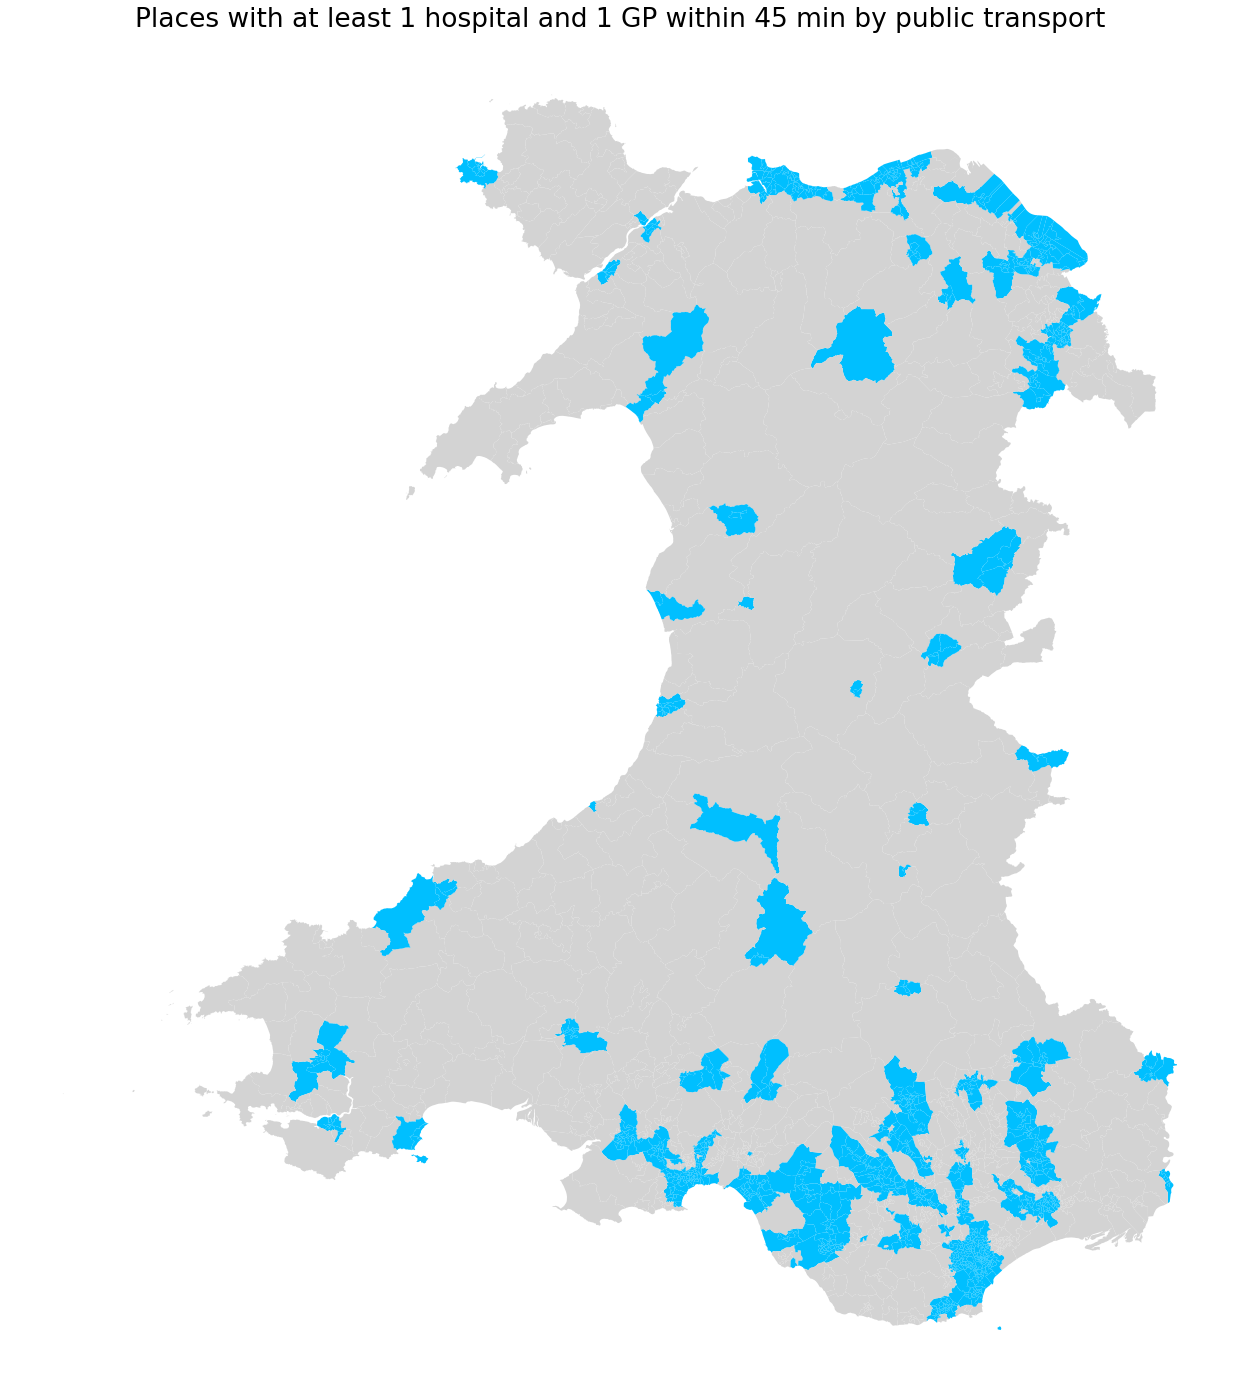

In [27]:
color = boundaries_wales['one_hosp_one_gp'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries_wales.plot(figsize=(25, 25),column ='one_hosp_one_gp',categorical=True, legend=True, color=color, edgecolor="face", linewidth=0.01)
plt.title("Places with at least 1 hospital and 1 GP within 45 min by public transport")
plt.axis('off')

(136161.30810000002, 365748.5979, 152965.62265, 407566.87834999996)

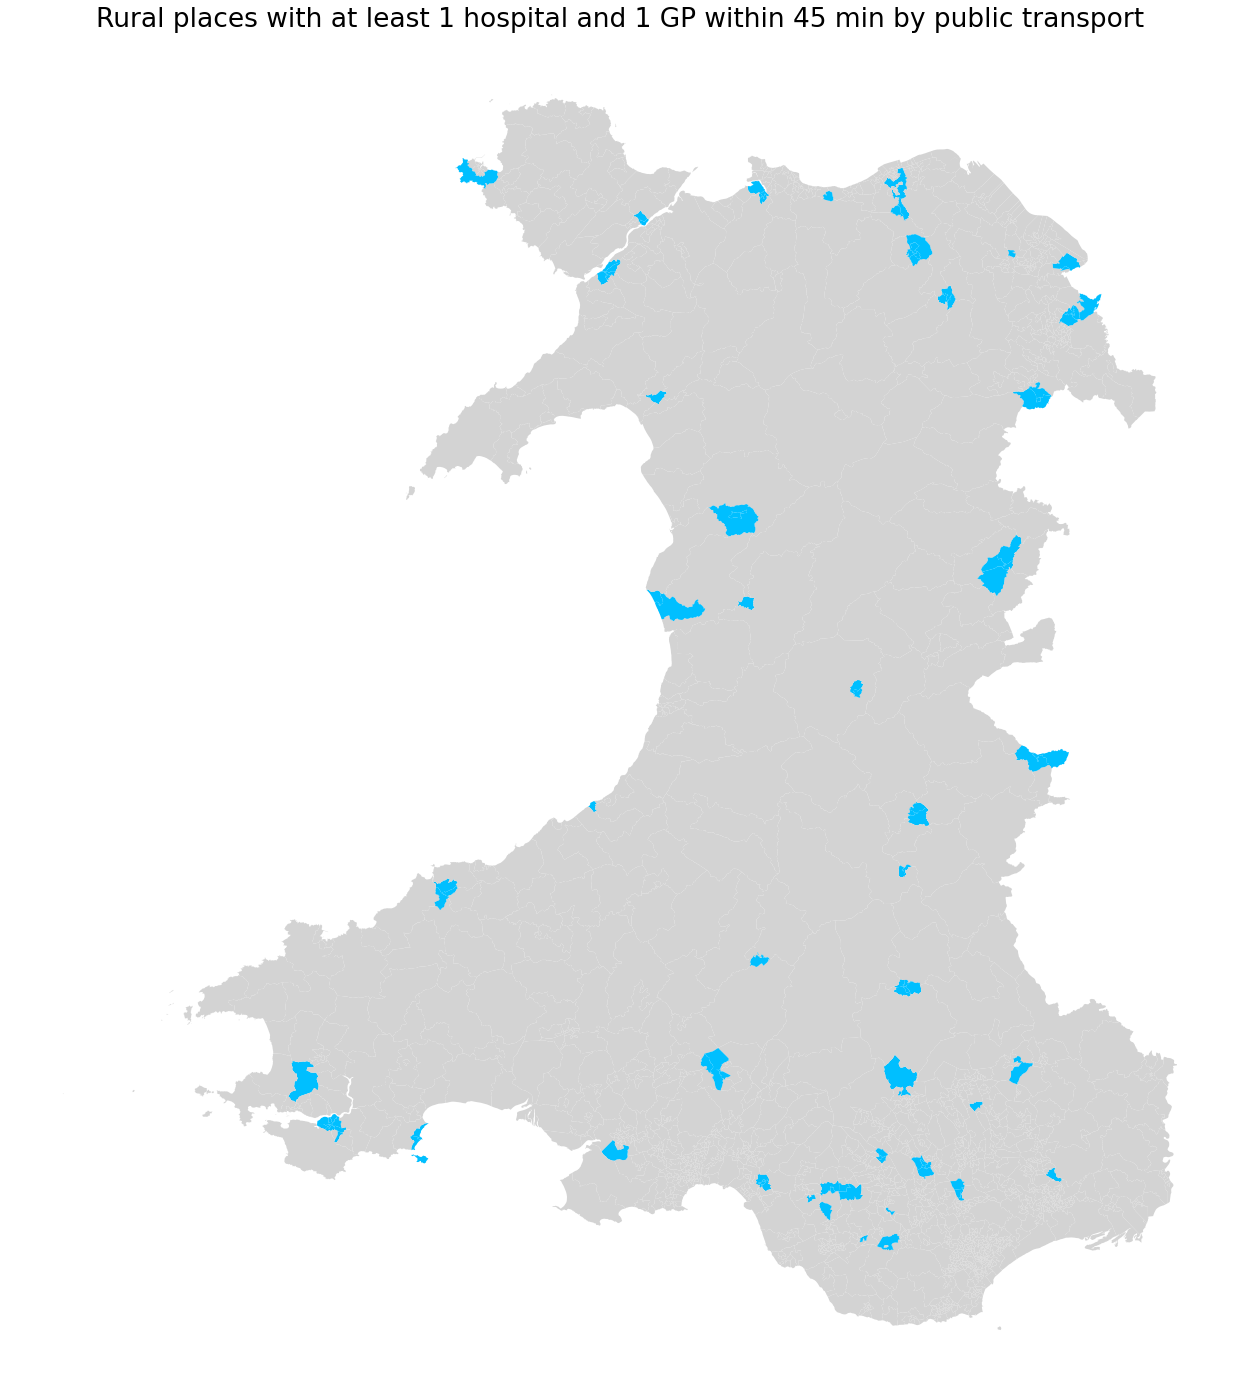

In [28]:
color_rural = boundaries_wales['one_hosp_one_gp_rural'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries_wales.plot(figsize=(25, 25),column ='one_hosp_one_gp',categorical=True, legend=True, color=color_rural, edgecolor="face", linewidth=0.01)
plt.title("Rural places with at least 1 hospital and 1 GP within 45 min by public transport")
plt.axis('off')

## England

In [29]:
boundaries_eng = boundaries.loc[boundaries['geo_code'].str.startswith('E01')]

(53976.32895, 684656.27005, -27279.692900000002, 690212.7949)

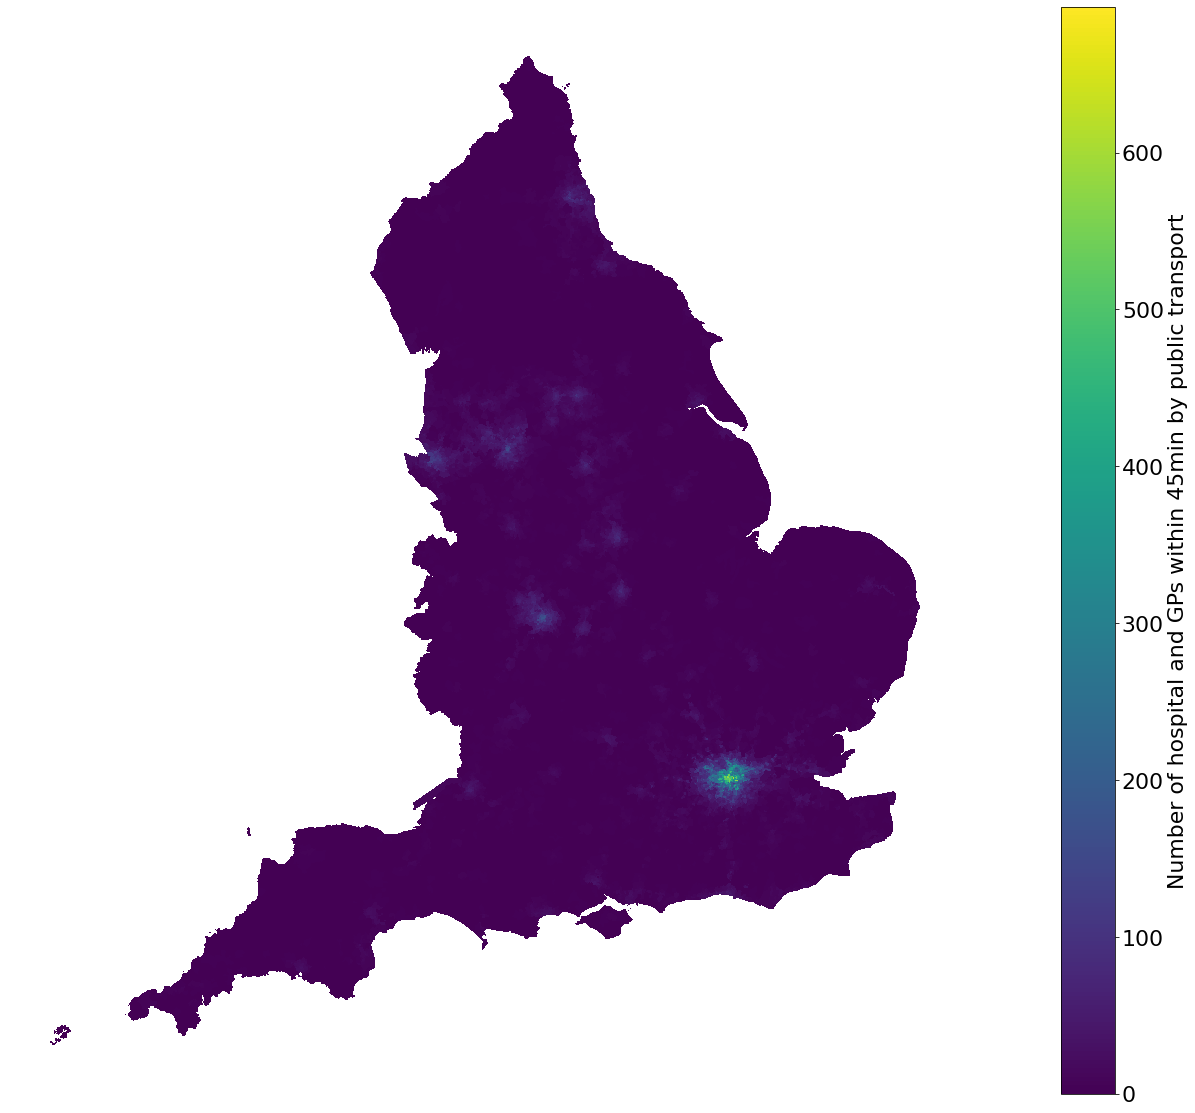

In [30]:
boundaries_eng.plot(figsize=(35, 20),column='healthcare_45', legend=True,
          legend_kwds={'label': "Number of hospital and GPs within 45min by public transport"},edgecolor="face", antialiased=False, linewidth=0.01)
plt.axis('off')

In [31]:
pop_eng = pop_gb.loc[pop_gb['geo_code'].str.startswith('E01')]

In [32]:
print(pop_eng['pop'].sum(), "people in England")
print(pop_eng.loc[pop_eng['geo_code'].isin(geo_codes_deprived_45), "pop"].sum(), "people can't reach an hospital and a GP in 30 min by pt")
print(round(pop_eng.loc[pop_eng['geo_code'].isin(geo_codes_deprived_45), "pop"].sum()/pop_eng['pop'].sum()*100,2), "% people can't reach an hospital or a GP in 30 min by pt")

56550138 people in England
12310357 people can't reach an hospital and a GP in 30 min by pt
21.77 % people can't reach an hospital or a GP in 30 min by pt


In [33]:
print(pop_eng["seniors"].sum(), "seniors 80+ in England")

print(pop_eng.loc[(pop_eng['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum(), "seniors in can't reach an hospital and a GP in 45 min by pt")
print(round(pop_eng.loc[(pop_eng['geo_code'].isin(geo_codes_deprived_45)), "seniors"].sum()/pop_eng["seniors"].sum()*100,2), "% seniors in England can't reach an hospital and a GP in 45 min by pt")

2855599 seniors 80+ in England
756965 seniors in can't reach an hospital and a GP in 45 min by pt
26.51 % seniors in England can't reach an hospital and a GP in 45 min by pt


(53976.32895, 684656.27005, -27279.692900000002, 690212.7949)

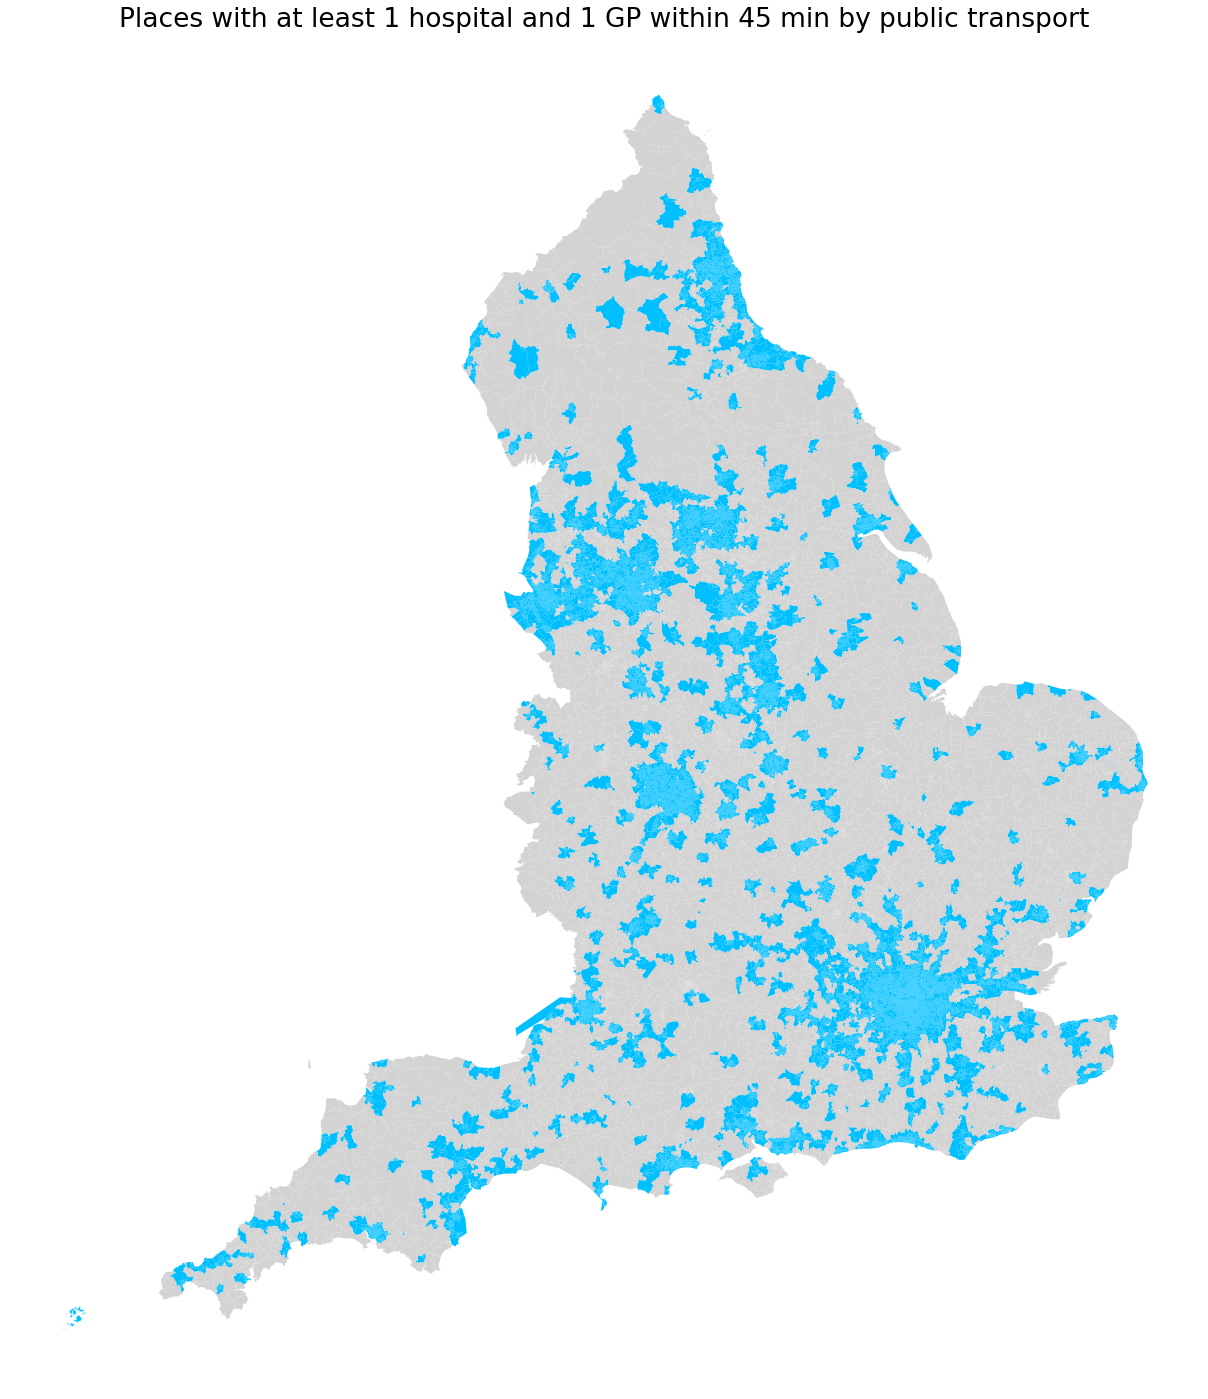

In [34]:
color = boundaries_eng['one_hosp_one_gp'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries_eng.plot(figsize=(25, 25),column ='one_hosp_one_gp',categorical=True, legend=True, color=color, edgecolor="face", linewidth=0.01)
plt.title("Places with at least 1 hospital and 1 GP within 45 min by public transport")
plt.axis('off')

(53976.32895, 684656.27005, -27279.692900000002, 690212.7949)

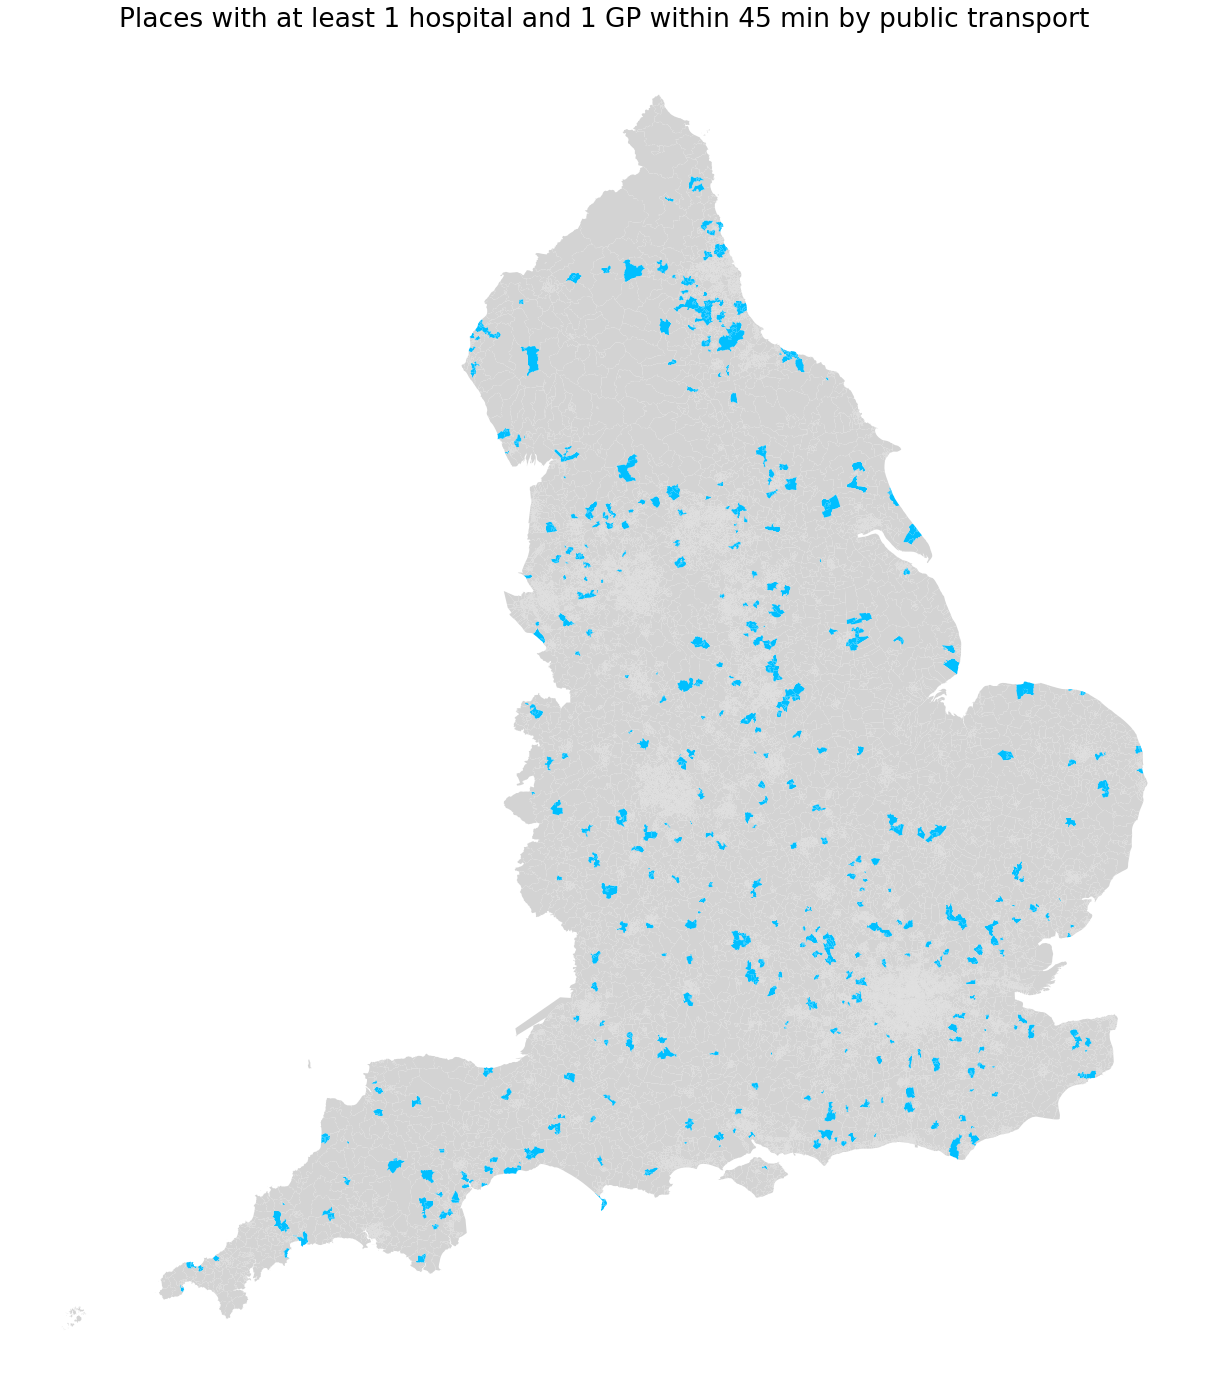

In [35]:
color_rural = boundaries_eng['one_hosp_one_gp_rural'].apply(lambda x: 'deepskyblue' if x==True else 'lightgrey')
boundaries_eng.plot(figsize=(25, 25),column ='one_hosp_one_gp',categorical=True, legend=True, color=color_rural, edgecolor="face", linewidth=0.01)
plt.title("Places with at least 1 hospital and 1 GP within 45 min by public transport")
plt.axis('off')